In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize

RDKit WARNING: [12:35:54] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE

os.makedirs(EXAMPLE_PATH, exist_ok=True)

Using backend: pytorch


In [3]:
with open(os.path.join(DATA_PATH, 'herg', 'data_herg.pt'), 'rb') as handle:
    inchis, values = pickle.load(handle)


with open(os.path.join(DATA_PATH, 'herg', 'sim_herg.pt'), 'rb') as handle:
    sim = pickle.load(handle)

preds = np.load(os.path.join(DATA_PATH, 'herg', 'preds.npy'))
diff_true = np.load(os.path.join(DATA_PATH, 'herg', 'diff_exp.npy'))
diff_hat = np.load(os.path.join(DATA_PATH, 'herg', 'diff_hat.npy'))

In [4]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [5]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [6]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [7]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [8]:
df_pairs.head(n=400)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,49431002,InChI=1S/C25H31ClN2O4/c26-24-15-23(5-4-20(24)1...,InChI=1S/C24H28Cl2N2O3/c25-22-5-4-21(15-23(22)...,0.290000,4.500000,0.341809,5.137936,0.846939,-4.210000,-4.796127,27.505333,31.334701
1,49431595,InChI=1S/C25H31ClN2O4/c26-23-15-21(6-5-19(23)1...,InChI=1S/C24H28Cl2N2O3/c25-21-6-5-19(15-22(21)...,0.190000,5.800001,0.466762,5.064156,0.846939,-5.610001,-4.597394,36.652007,30.036307
2,12335781,InChI=1S/C27H28N6O3/c1-17-19(13-28)12-21-24(31...,InChI=1S/C27H28N6O4/c1-35-25-18(13-28)12-20-23...,9.060481,8.795880,5.237367,8.670380,0.884956,0.264601,-3.433012,2.299991,29.840804
3,16939151,InChI=1S/C29H34N4O3/c1-35-25-8-4-5-9-26(25)36-...,InChI=1S/C30H33ClN2O3/c1-35-27-8-4-5-9-28(27)3...,0.800001,7.829981,1.001737,6.810951,0.779661,-7.029980,-5.809215,31.905292,26.364895
4,16947531,InChI=1S/C27H35ClN2O4/c28-25-17-24(7-6-22(25)1...,InChI=1S/C26H32Cl2N2O3/c27-23-7-6-22(17-24(23)...,0.120000,5.000001,1.553778,5.267647,0.855769,-4.880001,-3.713869,33.834668,25.749490
5,16944149,InChI=1S/C29H34N4O3/c1-35-25-8-4-5-9-26(25)36-...,InChI=1S/C29H33N3O3/c1-34-26-8-4-5-9-27(26)35-...,0.800001,7.429991,1.001737,6.675131,0.777778,-6.629990,-5.673394,29.834957,25.530275
6,23230390,InChI=1S/C26H32Cl2N6O3/c27-20-13-17-14-21(28)2...,InChI=1S/C27H34Cl2N6O3/c28-21-14-18-15-22(29)2...,4.886057,4.494850,5.110617,4.416240,0.972477,0.391207,0.694376,14.213848,25.229025
7,43087897,InChI=1S/C27H33Cl2FN2O3/c1-18-23(28)6-7-25(26(...,InChI=1S/C27H33Cl2FN2O3/c1-18-25(7-6-23(28)26(...,4.500000,4.300000,5.340643,3.485387,0.922330,0.199999,1.855257,2.574993,23.886423
8,17518445,InChI=1S/C32H33FN6O6/c33-22-15-35-23-2-4-28(43...,InChI=1S/C31H31FN6O6/c32-21-13-34-22-2-4-27(43...,6.045757,5.275724,5.040773,6.982836,0.918519,0.770033,-1.942063,9.450412,23.834421
9,12799709,InChI=1S/C29H33N3O4/c1-35-26-8-4-5-9-27(26)36-...,InChI=1S/C29H34N4O3/c1-35-25-8-4-5-9-26(25)36-...,6.669996,0.800001,6.387530,1.001737,0.764706,5.869995,5.385794,24.947481,22.889625


In [9]:
import torch
model_pt = os.path.join(MODELS_PATH, 'herg_noHs.pt')

from molgrad.net import MPNNPredictor

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

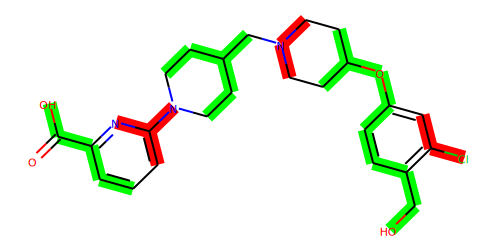

In [41]:
inchi_i, inchi_j = df_pairs.loc[107, 'inchi_i'], df_pairs.loc[107, 'inchi_j']  # could show
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_width=500,
                                                      img_height=250)
img

In [42]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_one_neg.svg"), "w+") as handle:
    handle.write(svg)

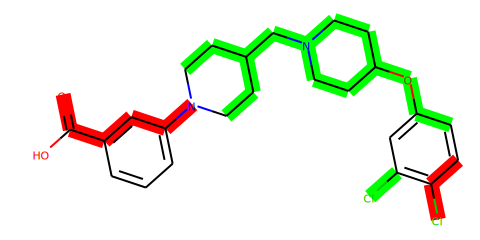

In [43]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_width=480,
                                                      img_height=240)
img

In [44]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_one_pos.svg"), "w+") as handle:
    handle.write(svg)

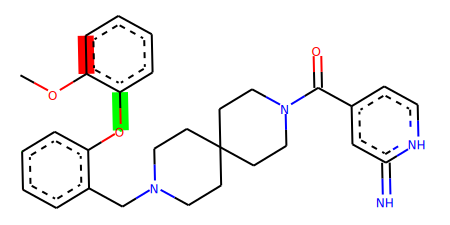

In [59]:
inchi_i, inchi_j = df_pairs.loc[3, 'inchi_i'], df_pairs.loc[3, 'inchi_j']  # could show
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=6.5e-3,
                                                      addHs=False,
                                                      img_width=450,
                                                      img_height=225)
img

In [46]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_two_neg.svg"), "w+") as handle:
    handle.write(svg)

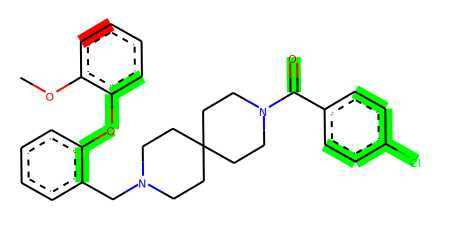

In [58]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=6.5e-3,
                                                      addHs=False,
                                                      img_width=450,
                                                      img_height=225)
img

In [48]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_two_pos.svg"), "w+") as handle:
    handle.write(svg)